# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

## Подготовка данных

Загрузка и подключение библиотек

In [1]:
!pip install --upgrade scikit-learn -q
!pip install phik -q
!pip install catboost -q
!pip install lightgbm -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import time
import numpy as np
import lightgbm as lgbm

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge

RANDOM_STATE=42

Загрузка данных

In [3]:
try:
    data=pd.read_csv('/datasets/autos.csv')
except FileNotFoundError:
    data=pd.read_csv('autos.csv')

Просмотр информации о данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Вывод первыъ строчек данных

In [5]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Приведение названий столбцов к "змеиному регистру"

In [6]:
data=data.rename(columns={'DateCrawled':'date_crawled', 
                     'Price':'price', 
                     'VehicleType':'vehicle_type', 
                     'RegistrationYear':'registration_year', 
                     'Gearbox':'gearbox', 
                     'Power':'power', 
                     'Model':'model', 
                     'Kilometer':'kilometer', 
                     'RegistrationMonth':'registration_month', 
                     'FuelType':'fuel_type', 
                     'Brand':'brand', 
                     'Repaired':'repaired', 
                     'DateCreated':'date_created', 
                     'NumberOfPictures':'number_of_pictures', 
                     'PostalCode':'postal_code', 
                     'LastSeen':'last_seen'}
           )
data.head(1)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57


Вывод количество пропусков по столбцам

In [7]:
i=0
for col in data.columns:
    print(i, col, data[col].isnull().sum())
    i+=1

0 date_crawled 0
1 price 0
2 vehicle_type 37490
3 registration_year 0
4 gearbox 19833
5 power 0
6 model 19705
7 kilometer 0
8 registration_month 0
9 fuel_type 32895
10 brand 0
11 repaired 71154
12 date_created 0
13 number_of_pictures 0
14 postal_code 0
15 last_seen 0


Количество дубликатов в data

In [8]:
data.duplicated().sum()

4

Удаление дубликатов из данных

In [9]:
data=data.drop_duplicates()

Просмотр уникальных значений на наличие неявных дубликатов (так, по крайней мере, было задумано)

Изменение типа данных в столбиках 'date_crawled', 'date_created', 'last_seen' на datetime64

In [10]:
data['date_crawled']=pd.to_datetime(data['date_crawled'], format='%Y-%m-%d %H:%M:%S')
data['date_created']=pd.to_datetime(data['date_created'], format='%Y-%m-%d %H:%M:%S')
data['last_seen']=pd.to_datetime(data['last_seen'], format='%Y-%m-%d %H:%M:%S')

Просмотр информации о данных после изменения типа

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  datetime64[ns]
 1   price               354365 non-null  int64         
 2   vehicle_type        316875 non-null  object        
 3   registration_year   354365 non-null  int64         
 4   gearbox             334532 non-null  object        
 5   power               354365 non-null  int64         
 6   model               334660 non-null  object        
 7   kilometer           354365 non-null  int64         
 8   registration_month  354365 non-null  int64         
 9   fuel_type           321470 non-null  object        
 10  brand               354365 non-null  object        
 11  repaired            283211 non-null  object        
 12  date_created        354365 non-null  datetime64[ns]
 13  number_of_pictures  354365 no

Гистограмма цен на автомобили

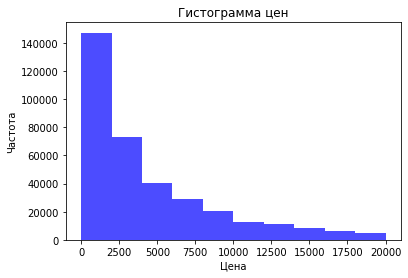

In [12]:
plt.hist(data['price'], bins=10, color='blue', alpha=0.7)
plt.title('Гистограмма цен')
plt.xlabel('Цена')
plt.ylabel('Частота');

График боксплот для цен на автомобиль

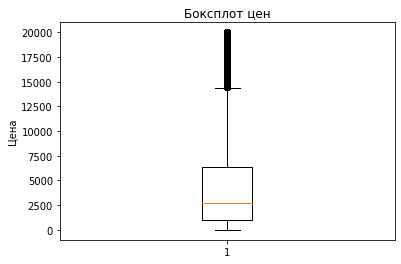

In [13]:
plt.boxplot(data['price'])
plt.title('Боксплот цен')
plt.ylabel('Цена');

Могу предположить, что с машинами, которые стоят до 100 евро (на данный момент 10000 руб.), что-то не так. Особенно с марками по типу Mercedes-Benz, Volkswagen, Suzuki и т.д. Думаю, эти данные можно удалить, пока это 3,8% от всех данных.

In [14]:
data.loc[data['price']<100]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28,0,40589,2016-04-06 12:15:54
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19,0,21698,2016-04-01 08:47:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10,0,22559,2016-03-12 23:46:32
354309,2016-03-09 22:37:41,99,small,1999,manual,60,arosa,150000,1,petrol,seat,yes,2016-03-09,0,91301,2016-04-06 22:15:32


Удаление информации о машинах стоимость меньше 100

In [15]:
data = data[data['price'] >= 100]

Заполнение пропусков в столбце vehicle_type на Unknown и вывод информации

In [16]:
data['vehicle_type'].fillna('Unknown', inplace=True)
data['vehicle_type'].isnull().sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341051 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        341051 non-null  datetime64[ns]
 1   price               341051 non-null  int64         
 2   vehicle_type        341051 non-null  object        
 3   registration_year   341051 non-null  int64         
 4   gearbox             324737 non-null  object        
 5   power               341051 non-null  int64         
 6   model               324018 non-null  object        
 7   kilometer           341051 non-null  int64         
 8   registration_month  341051 non-null  int64         
 9   fuel_type           312702 non-null  object        
 10  brand               341051 non-null  object        
 11  repaired            276694 non-null  object        
 12  date_created        341051 non-null  datetime64[ns]
 13  number_of_pictures  341051 no

Просмотр уникальных значений в солбце registration_year

In [17]:
sorted(data['registration_year'].unique())

[1000,
 1001,
 1039,
 1111,
 1234,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1800,
 1910,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 7000,
 7100,
 7800,
 8200,
 8500,
 8888,
 9000,
 9450,
 9999]

Это я пытался понять почему год регистрации находится в данном диапазоне

In [18]:
data.loc[data['registration_year']==1000]
data.loc[data['registration_year']==9999]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
17271,2016-03-23 16:43:29,700,Unknown,9999,NaN,0,other,10000,0,NaN,opel,NaN,2016-03-23,0,21769,2016-04-05 20:16:15
28390,2016-04-05 08:57:08,799,Unknown,9999,NaN,0,3er,10000,4,petrol,bmw,NaN,2016-04-05,0,72116,2016-04-07 12:17:50
28965,2016-04-04 22:54:47,18000,Unknown,9999,NaN,0,a_klasse,10000,0,petrol,mercedes_benz,NaN,2016-04-04,0,51379,2016-04-07 02:44:52
29426,2016-03-23 21:52:25,7999,Unknown,9999,NaN,0,kaefer,10000,0,NaN,volkswagen,NaN,2016-03-23,0,47638,2016-04-06 03:46:40
128677,2016-03-14 14:51:56,1550,Unknown,9999,NaN,95,NaN,10000,0,NaN,volkswagen,NaN,2016-03-14,0,35288,2016-03-16 04:48:21
149151,2016-04-02 18:57:33,400,Unknown,9999,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-04-02,0,26441,2016-04-02 18:57:33
167937,2016-03-23 13:49:51,1000,Unknown,9999,NaN,0,NaN,10000,0,NaN,mazda,NaN,2016-03-23,0,40822,2016-03-23 13:49:51
200525,2016-03-22 15:56:52,850,Unknown,9999,NaN,0,NaN,10000,0,NaN,mazda,NaN,2016-03-22,0,40822,2016-03-22 15:56:52
217111,2016-03-26 13:55:09,850,Unknown,9999,NaN,0,3er,10000,0,NaN,bmw,no,2016-03-26,0,77746,2016-03-31 09:15:47
227462,2016-03-14 12:51:55,2850,Unknown,9999,NaN,0,other,10000,0,NaN,fiat,NaN,2016-03-14,0,17335,2016-04-05 13:15:26


Удаление аномальных значений

In [19]:
data = data.loc[(data['registration_year'] <= 2016) & (data['registration_year'] >= 1950)]

Вывод строк из столбика gearbox в которых есть пропуски

In [20]:
data.loc[data['gearbox'].isna()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
16,2016-04-01 12:46:46,300,Unknown,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,Unknown,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01,0,47249,2016-04-07 08:46:07
92,2016-03-16 07:56:19,250,Unknown,2000,NaN,60,ka,150000,0,NaN,ford,NaN,2016-03-16,0,51427,2016-03-21 09:47:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354288,2016-03-16 13:36:25,3300,wagon,2006,NaN,0,touran,150000,7,gasoline,volkswagen,NaN,2016-03-16,0,12057,2016-03-17 12:17:07
354305,2016-04-03 13:46:24,3500,Unknown,1995,NaN,0,polo,150000,0,NaN,volkswagen,NaN,2016-04-03,0,74579,2016-04-05 12:44:38
354329,2016-03-30 20:55:30,350,small,1996,NaN,65,punto,150000,0,NaN,fiat,NaN,2016-03-30,0,25436,2016-04-07 13:50:41
354338,2016-03-31 19:52:33,180,Unknown,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31,0,41470,2016-04-06 14:18:04


Поиск колонок которые совпадают пропусками с gearbox. Если совпадений будет много значит строчки можно будет удалить.

In [21]:
for col in data.columns:
    if col != 'gearbox':
        count = data.loc[data['gearbox'].isna() & data[col].isna()].shape[0]
        print(f"Количество совпадающих пропусков со столбцом: '{col}': {count}")

Количество совпадающих пропусков со столбцом: 'date_crawled': 0
Количество совпадающих пропусков со столбцом: 'price': 0
Количество совпадающих пропусков со столбцом: 'vehicle_type': 0
Количество совпадающих пропусков со столбцом: 'registration_year': 0
Количество совпадающих пропусков со столбцом: 'power': 0
Количество совпадающих пропусков со столбцом: 'model': 2379
Количество совпадающих пропусков со столбцом: 'kilometer': 0
Количество совпадающих пропусков со столбцом: 'registration_month': 0
Количество совпадающих пропусков со столбцом: 'fuel_type': 5556
Количество совпадающих пропусков со столбцом: 'brand': 0
Количество совпадающих пропусков со столбцом: 'repaired': 8529
Количество совпадающих пропусков со столбцом: 'date_created': 0
Количество совпадающих пропусков со столбцом: 'number_of_pictures': 0
Количество совпадающих пропусков со столбцом: 'postal_code': 0
Количество совпадающих пропусков со столбцом: 'last_seen': 0


Удаление пропусков еще 4.6% (суммарно удалено 8.4%)

In [22]:
data.dropna(subset=['gearbox'], inplace=True)

Вывод информации после проделанной операции

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312657 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        312657 non-null  datetime64[ns]
 1   price               312657 non-null  int64         
 2   vehicle_type        312657 non-null  object        
 3   registration_year   312657 non-null  int64         
 4   gearbox             312657 non-null  object        
 5   power               312657 non-null  int64         
 6   model               299908 non-null  object        
 7   kilometer           312657 non-null  int64         
 8   registration_month  312657 non-null  int64         
 9   fuel_type           295135 non-null  object        
 10  brand               312657 non-null  object        
 11  repaired            262808 non-null  object        
 12  date_created        312657 non-null  datetime64[ns]
 13  number_of_pictures  312657 no

Вывод отсортированного списка уникальных значений в столбце power

In [24]:
sorted(data['power'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


Описательная статистика 

In [25]:
data['power'].describe()

count    312657.000000
mean        115.753343
std         184.970827
min           0.000000
25%          75.000000
50%         107.000000
75%         144.000000
max       20000.000000
Name: power, dtype: float64

Можно заметить очень высокое максимальное значение и непонятный минимум

Вывод строк где мощность равна нулю

In [26]:
data.loc[data['power']==0]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,Unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,2016-03-17,0,88433,2016-04-04 04:17:32
55,2016-03-26 10:39:35,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,2016-03-26,0,56759,2016-04-01 23:17:27
70,2016-03-08 01:36:42,800,small,1993,manual,0,polo,150000,3,petrol,volkswagen,no,2016-03-08,0,8258,2016-04-05 23:46:00
90,2016-03-23 11:53:21,2400,sedan,2003,manual,0,a4,150000,9,gasoline,audi,NaN,2016-03-23,0,40210,2016-03-23 11:53:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354332,2016-03-13 15:45:22,7900,bus,2007,manual,0,b_klasse,125000,1,petrol,mercedes_benz,no,2016-03-13,0,30519,2016-03-27 00:18:05
354335,2016-04-04 14:41:28,390,small,1997,auto,0,corsa,100000,6,petrol,opel,yes,2016-04-04,0,17509,2016-04-06 15:46:11
354336,2016-03-05 18:57:45,3299,Unknown,2005,auto,0,outlander,150000,4,petrol,mitsubishi,NaN,2016-03-05,0,17034,2016-03-06 04:17:37
354346,2016-03-07 17:06:35,2600,Unknown,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07,0,61169,2016-03-08 21:28:38


Просмотр информации о машине с невероятным количеством сил

In [27]:
data.loc[data['power']==20000]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
219584,2016-03-09 15:43:53,4300,coupe,1999,auto,20000,clk,150000,1,petrol,mercedes_benz,no,2016-03-09,0,19406,2016-03-30 08:47:08


Сравнил с реальной мощностью данной машины и могу предположить что здесь ошиблись в 100 раз

Далее выборочно проверю машины с огромным количеством лошадиных сил

In [28]:
data.loc[data['power']==12512]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
292167,2016-03-21 12:49:22,2000,bus,2003,manual,12512,zafira,150000,12,petrol,opel,NaN,2016-03-21,0,52072,2016-04-06 07:45:32
346639,2016-03-25 12:55:36,1300,sedan,2000,manual,12512,carisma,150000,9,petrol,mitsubishi,NaN,2016-03-25,0,42105,2016-04-06 14:44:53


Аналогичная ситуация по всем трем машинам

In [29]:
data.loc[data['power']==17019]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
187330,2016-03-17 19:50:23,1749,wagon,1989,manual,17019,3er,5000,12,petrol,bmw,NaN,2016-03-17,0,89542,2016-03-26 00:46:59


В данном случае таккая же ошибка

Делаю вывод что машины у которых мощность измеряется в десятках тысяч лошадиных сил везде ондна и та же ошибка. Значит можем разделить значения на 100

Далее хочу проверить машины которые находятся в диапазоне 2000-10000

In [30]:
data.loc[data['power']==7518]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
341320,2016-03-29 21:40:33,1899,other,2006,manual,7518,berlingo,125000,11,petrol,citroen,yes,2016-03-29,0,89428,2016-03-31 15:17:03


Опять в сто раз

In [31]:
data.loc[data['power']==9007]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
277113,2016-03-19 16:49:47,2890,bus,2005,manual,9007,c_max,150000,2,petrol,ford,no,2016-03-19,0,25813,2016-03-19 16:49:47


Тут не понятно реальная мощность 125-145 л.с

In [32]:
data.loc[data['power']==3454]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
131401,2016-03-22 16:38:44,4500,sedan,2001,auto,3454,e_klasse,150000,6,petrol,mercedes_benz,NaN,2016-03-22,0,67433,2016-03-25 08:45:20


Реальная мощность 184-204. Пока 2 не очень приятных примера с которыми не знаю что делать. По сути я хочу найти границу где люди ошиблись в 100 раз и 10

In [33]:
data.loc[data['power']==2000]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
172462,2016-03-20 20:51:27,3000,wagon,2002,manual,2000,other,5000,2,gasoline,citroen,no,2016-03-20,0,50127,2016-03-24 14:17:59
301617,2016-04-04 21:39:53,10500,sedan,2006,manual,2000,golf,150000,10,petrol,volkswagen,no,2016-04-04,0,21502,2016-04-07 00:15:34


Фольцваген отличается в 20 раз остальные примерно так же обнаружена новая грань люди ошиблись в 20 раз это очень странная ошибка

Я выделил четыре группы:
- 1000-2000 разница в 10 раз
- 2000-4000 разница в 20 раз
- 4000-7500 разница в 50 раз
- 7500-20000 разница в 100 раз

А дальше идет разнообразие ошибок 
Значение, где мощность равна нулю, как будто, можно удалить. Но процент удаленных данных уже 8.4%, а по правильному это число не может превышать 10% данных. Я не знаю как сделать по другому.

Еще 7% данных было удалено итого суммарно 15,4%

In [34]:
data = data[data['power'] != 0]

Информация о данных

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290383 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        290383 non-null  datetime64[ns]
 1   price               290383 non-null  int64         
 2   vehicle_type        290383 non-null  object        
 3   registration_year   290383 non-null  int64         
 4   gearbox             290383 non-null  object        
 5   power               290383 non-null  int64         
 6   model               279947 non-null  object        
 7   kilometer           290383 non-null  int64         
 8   registration_month  290383 non-null  int64         
 9   fuel_type           276208 non-null  object        
 10  brand               290383 non-null  object        
 11  repaired            250126 non-null  object        
 12  date_created        290383 non-null  datetime64[ns]
 13  number_of_pictures  290383 no

Пытаемся исправить выделенные ранее группы

In [36]:
range_1_2 = (data['power'] > 1000) & (data['power'] <= 2000)
range_2_4 = (data['power'] > 2000) & (data['power'] <= 4000)
range_4_7 = (data['power'] > 4000) & (data['power'] <= 7500)
range_7_20 = (data['power'] > 7500) & (data['power'] <= 20000)
data.loc[range_1_2, 'power'] /= 10
data.loc[range_2_4, 'power'] /= 20
data.loc[range_4_7, 'power'] /= 50
data.loc[range_7_20, 'power'] /= 100
data['power'] = data['power'].round()
data['power']=data['power'].astype(int)

Описательная статистика после изменения

In [37]:
data['power'].describe()

count    290383.000000
mean        121.182462
std          54.640053
min           1.000000
25%          77.000000
50%         113.000000
75%         150.000000
max        1000.000000
Name: power, dtype: float64

Вывод отсортированного списка 

In [38]:
data['power'].sort_values(inplace=False)

311834       1
33223        1
94319        1
196897       1
268929       1
          ... 
301843     998
214420     999
260366     999
209422    1000
119692    1000
Name: power, Length: 290383, dtype: int64

Просмотр значений которые ниже или равно 20 лошадиным сил

In [39]:
data.loc[data['power']<=20]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
431,2016-03-20 20:45:27,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,no,2016-03-20,0,90562,2016-04-03 04:17:08
4637,2016-03-21 00:36:23,870,wagon,2000,manual,16,focus,150000,0,NaN,ford,no,2016-03-21,0,66693,2016-03-21 08:40:31
9561,2016-04-04 07:58:34,9000,sedan,2009,manual,2,a4,5000,12,gasoline,audi,NaN,2016-04-04,0,12045,2016-04-06 10:17:01
11228,2016-03-10 15:39:12,9900,small,1970,manual,18,500,30000,0,petrol,fiat,no,2016-03-10,0,73278,2016-04-05 11:49:04
11852,2016-03-18 08:36:43,1999,coupe,1964,manual,10,NaN,150000,6,petrol,sonstige_autos,NaN,2016-03-18,0,74918,2016-03-21 06:47:31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348975,2016-03-19 21:53:10,1850,small,2003,auto,5,NaN,50000,3,gasoline,sonstige_autos,yes,2016-03-19,0,13347,2016-04-03 14:44:50
350502,2016-03-07 13:51:22,6200,small,1964,manual,20,NaN,40000,6,petrol,sonstige_autos,no,2016-03-07,0,41334,2016-04-07 02:44:20
353127,2016-03-26 18:53:12,8600,convertible,2012,manual,8,NaN,5000,3,gasoline,sonstige_autos,no,2016-03-26,0,82399,2016-04-06 08:17:29
353447,2016-03-27 00:46:19,2900,small,1969,manual,18,500,5000,8,petrol,fiat,no,2016-03-26,0,74076,2016-03-28 17:45:04


Удаление этих значений

In [40]:
data = data[data['power'] > 20]

Просмотр пропущенных значений в столбце model

In [41]:
data['model'].isna().sum()

10245

Удаление пропусков (это еще 3.2% суммарно 18.6%) 

In [42]:
data.dropna(subset=['model'], inplace=True)

Вывод информации о данных

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279775 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        279775 non-null  datetime64[ns]
 1   price               279775 non-null  int64         
 2   vehicle_type        279775 non-null  object        
 3   registration_year   279775 non-null  int64         
 4   gearbox             279775 non-null  object        
 5   power               279775 non-null  int64         
 6   model               279775 non-null  object        
 7   kilometer           279775 non-null  int64         
 8   registration_month  279775 non-null  int64         
 9   fuel_type           267952 non-null  object        
 10  brand               279775 non-null  object        
 11  repaired            242831 non-null  object        
 12  date_created        279775 non-null  datetime64[ns]
 13  number_of_pictures  279775 no

Гистограмма пробега

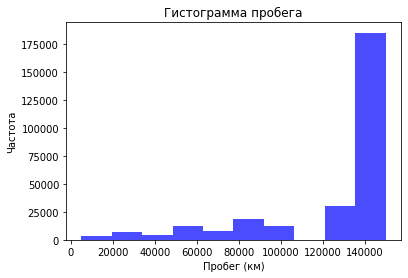

In [44]:
plt.hist(data['kilometer'], bins=10, color='blue', alpha=0.7)
plt.title('Гистограмма пробега')
plt.xlabel('Пробег (км)')
plt.ylabel('Частота');

График боксплот пробега

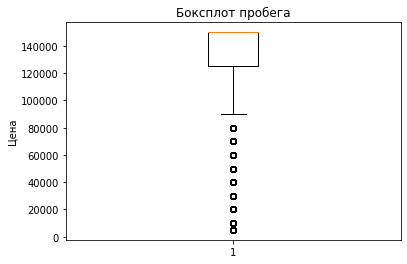

In [45]:
plt.boxplot(data['kilometer'])
plt.title('Боксплот пробега')
plt.ylabel('Цена');

Просмотр уникальных значений в столбце registration_month

In [46]:
data['registration_month'].unique()

array([ 8,  6,  7, 10,  0, 12, 11,  2,  3,  1,  4,  5,  9])

Просмотр моды в столбце registration_month

In [47]:
data['registration_month'].mode()

0    3
dtype: int64

Замена нулей на моду (3)

In [48]:
data['registration_month'] = data['registration_month'].replace(0, 3)

Вывод отсортированных уникальных значений в столбике registration_month для выявления неявных дубликатов

In [49]:
sorted(data['registration_month'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Вывод уникальных значений для столбца fuel_type

In [50]:
data['fuel_type'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Заполнение пропусков значением other

In [51]:
data['fuel_type']=data['fuel_type'].fillna('other')

Вывод информации после проделанных операций

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279775 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        279775 non-null  datetime64[ns]
 1   price               279775 non-null  int64         
 2   vehicle_type        279775 non-null  object        
 3   registration_year   279775 non-null  int64         
 4   gearbox             279775 non-null  object        
 5   power               279775 non-null  int64         
 6   model               279775 non-null  object        
 7   kilometer           279775 non-null  int64         
 8   registration_month  279775 non-null  int64         
 9   fuel_type           279775 non-null  object        
 10  brand               279775 non-null  object        
 11  repaired            242831 non-null  object        
 12  date_created        279775 non-null  datetime64[ns]
 13  number_of_pictures  279775 no

Уникальные значения в стобце brand

In [53]:
data['brand'].unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'porsche', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

Вывод уникальных значений в столбце repaired

In [54]:
data['repaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

Заполнение пропусков значением Unknown

In [55]:
data['repaired'].fillna('Unknown', inplace=True)

Просмотр уникальных значений после проделанной операции

In [56]:
data['repaired'].unique()

array(['Unknown', 'no', 'yes'], dtype=object)

Просмотр столбиков date_created и last_seen

In [57]:
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,Unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39


С этими столбиками делать ничего не будем

In [58]:
data['number_of_pictures'].unique()

array([0])

Столбец который состоит только из нулей не несет никакой информации удалим его

Удаление столбика

In [59]:
data=data.drop(['number_of_pictures'], axis=1)

Вывод информации о данных после удаления столбика

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279775 entries, 2 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        279775 non-null  datetime64[ns]
 1   price               279775 non-null  int64         
 2   vehicle_type        279775 non-null  object        
 3   registration_year   279775 non-null  int64         
 4   gearbox             279775 non-null  object        
 5   power               279775 non-null  int64         
 6   model               279775 non-null  object        
 7   kilometer           279775 non-null  int64         
 8   registration_month  279775 non-null  int64         
 9   fuel_type           279775 non-null  object        
 10  brand               279775 non-null  object        
 11  repaired            279775 non-null  object        
 12  date_created        279775 non-null  datetime64[ns]
 13  postal_code         279775 no

Вывод уникальных значений в столбце postal_code

In [61]:
len(data['postal_code'].unique())

8100

In [62]:
data["postal_code"]=data["postal_code"].astype('str')
index = []
for word in np.array(data['postal_code']):
    number = word[0]
    index.append(number)
data["postal_index"]=index
data["postal_index"]=data["postal_index"].astype('int')

In [63]:
data["postal_index"].unique()

array([9, 6, 3, 2, 5, 4, 8, 7, 1])

Оставим этот столбик впокое с ним все нормально

Далее проведем предварительный анализ данных

Отбор числовых признаков

In [64]:
num_columns=[]
for column in data.select_dtypes(include=['int']):
    num_columns.append(column)
num_columns

['price',
 'registration_year',
 'power',
 'kilometer',
 'registration_month',
 'postal_index']

Отбор категориальных признаков

In [65]:
str_columns=[]
for column in data.select_dtypes(include=['object']):
    str_columns.append(column)
str_columns.remove('postal_code')
str_columns

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

Отбор столбиков тип данных которых datetime

In [66]:
time_columns=[]
for column in data.select_dtypes(include=['datetime']):
    time_columns.append(column)
time_columns

['date_crawled', 'date_created', 'last_seen']

Просмотр  данных с числовыми столбиками

In [67]:
data[num_columns].head()

,price,registration_year,power,kilometer,registration_month,postal_index
2,9800,2004,163,125000,8,9
3,1500,2001,75,150000,6,9
4,3600,2008,69,90000,7,6
5,650,1995,102,150000,10,3
6,2200,2004,109,150000,8,6


Построение матрицы корреляции 

In [68]:
combined_columns = num_columns + str_columns

In [69]:
phik_matrix = data[combined_columns].phik_matrix(interval_cols=num_columns)
phik_matrix

,price,registration_year,power,kilometer,registration_month,postal_index,vehicle_type,gearbox,model,fuel_type,brand,repaired
price,1.000000,0.658118,0.475004,0.317388,0.099417,0.054697,0.270886,0.328261,0.579047,0.267228,0.338761,0.328815
registration_year,0.658118,1.000000,0.228265,0.392643,0.093224,0.038980,0.253934,0.117542,0.628524,0.264783,0.317768,0.200564
power,0.475004,0.228265,1.000000,0.079161,0.048670,0.051910,0.370584,0.546138,0.702528,0.216204,0.484283,0.091569
kilometer,0.317388,0.392643,0.079161,1.000000,0.034538,0.049333,0.250287,0.026543,0.447497,0.151246,0.269026,0.220411
registration_month,0.099417,0.093224,0.048670,0.034538,1.000000,0.023748,0.096458,0.047900,0.133517,0.095625,0.066540,0.150987
postal_index,0.054697,0.038980,0.051910,0.049333,0.023748,1.000000,0.081683,0.081656,0.198007,0.050531,0.149539,0.064967
vehicle_type,0.270886,0.253934,0.370584,0.250287,0.096458,0.081683,1.000000,0.215640,0.906700,0.392078,0.593974,0.292018
gearbox,0.328261,0.117542,0.546138,0.026543,0.047900,0.081656,0.215640,1.000000,0.644232,0.150621,0.495739,0.021437
model,0.579047,0.628524,0.702528,0.447497,0.133517,0.198007,0.906700,0.644232,1.000000,0.536098,0.998398,0.218994
fuel_type,0.267228,0.264783,0.216204,0.151246,0.095625,0.050531,0.392078,0.150621,0.536098,1.000000,0.282471,0.165400


Для наглядности построим heatmap

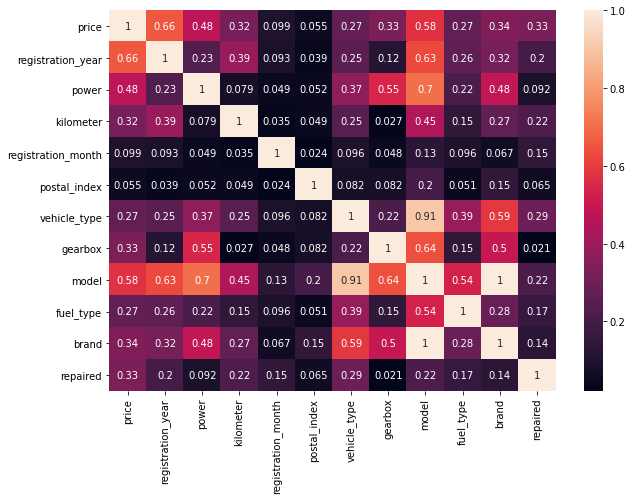

In [70]:
plt.figure(figsize=(10,7))
sns.heatmap(phik_matrix, annot=True);

- price и registration_year (корреляции почти нет)
- price и power (сильная корреляция)
- price и killometer (высокая корреляция)
- price и registration_month (корреляции низкая)

Построим графики линейной регресии

In [71]:
for col in num_columns:
    if col != 'price': 
        plt.figure()
        sns.regplot(x='price', y=col, data=data)
        plt.title(f'Линейная регрессия между price и {col}')

На графике линейной регрессии между стоимостью автомобилей и годом выпуска видно, что стоимость автомобилей увеличивается с каждым годом. Это указывает на положительную линейную зависимость между этими двумя переменными.

<b>Промежуточный вывод:</b>
1. Загрузка данных:
- Данные были загружены из источника (CSV-файл) в DataFrame с использованием библиотеки pandas.
2. Предобработка данных:
- Удаление пропусков. Пропущенные значения были удалены или заменены на адекватные значения (например, мода значение по столбцу).
- Удаление дубликатов. Дубликаты записей были удалены для обеспечения уникальности данных.
- Преобразование типов данных. Необходимые столбцы были преобразованы в соответствующие типы данных (например, столбцы с датами были преобразованы в тип datetime).
3. Предварительный анализ данных. 
- Была вычислена матрица корреляции для числовых столбцов, чтобы определить взаимосвязи между переменными.
- Были построены графики линейной зависимости.

## Обучение моделей

Склейка данных для обучения (столбики с категориальными столбцами и числовыми)

In [72]:
data_find=data[combined_columns]
data_find=data_find.reset_index(drop=True)
data_find.head()

,price,registration_year,power,kilometer,registration_month,postal_index,vehicle_type,gearbox,model,fuel_type,brand,repaired
0,9800,2004,163,125000,8,9,suv,auto,grand,gasoline,jeep,Unknown
1,1500,2001,75,150000,6,9,small,manual,golf,petrol,volkswagen,no
2,3600,2008,69,90000,7,6,small,manual,fabia,gasoline,skoda,no
3,650,1995,102,150000,10,3,sedan,manual,3er,petrol,bmw,yes
4,2200,2004,109,150000,8,6,convertible,manual,2_reihe,petrol,peugeot,no


Выявление и удаление дубликатов, образовавшихся после предобработки

In [73]:
data_find.duplicated().sum()

20183

In [74]:
data_find=data_find.drop_duplicates()
data_find.duplicated().sum()

0

Разделение данных (целевой и основной признак)

In [75]:
features=data_find.drop(['price'], axis=1)
target=data_find['price']

Для личного удобства переименовал числовые признаки.

In [77]:
num_columns_ml=num_columns
num_columns_ml.remove('price')

In [78]:
num_columns_ml

['registration_year',
 'power',
 'kilometer',
 'registration_month',
 'postal_index']

Для личного удобства преименовал категориальные признаки

In [79]:
str_columns_ml=str_columns

In [80]:
str_columns_ml

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

Обьединение колонок с признаками

In [81]:
all_columns_ml = str_columns_ml + num_columns_ml

Разделение данных на тренировочную и тестовую

In [82]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

Разделение данных на тренировочную и валидационную

In [83]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

Подготовка столбцов для преобразования

In [84]:
ohe_features_rf=str_columns_ml.copy()
ohe_features_rf.remove('model')
ohe_features_rf

['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']

In [85]:
num_features=num_columns_ml.copy()
num_features.remove('registration_month')
num_features.remove('postal_index')
num_features

['registration_year', 'power', 'kilometer']

Сравним уникальные значения столбца 'model' в тренировочной и тестовой выборках

In [86]:
models_train = set(X_train['model'].unique())
models_test = set(X_test['model'].unique())
num_models_train = len(models_train)
num_models_test = len(models_test)
print(f'''
Только в тренировочной выборке есть значения: {models_train - models_test}
''')
print(f'''
Только в тестовой выборке есть значения: {models_test - models_train}
''')


Только в тренировочной выборке есть значения: {'kalina', 'serie_3'}


Только в тестовой выборке есть значения: {'range_rover_evoque'}



Есть значения которые уникальны для тренировочных выборок и тестовых

In [87]:
X_train_ridge = X_train.copy()
X_val_ridge = X_val.copy()
X_test_ridge = X_test.copy()

Закодируем категориальные признаки с использованием OneHotEncoder для тренировочной, валидационной и тестовой выборок

In [88]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
encoder_ohe.fit(X_train_ridge[str_columns_ml])

X_train_ridge[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_train_ridge[str_columns_ml])
X_train_ridge = X_train_ridge.drop(str_columns_ml, axis=1)

X_val_ridge[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_val_ridge[str_columns_ml])
X_val_ridge = X_val_ridge.drop(str_columns_ml, axis=1)

X_test_ridge[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_test_ridge[str_columns_ml])
X_test_ridge = X_test_ridge.drop(str_columns_ml, axis=1)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Промасштабируем числовые признаки с использованием StandardScaler для тренировочной, валидационной и тестовой выборок

In [89]:
scaler = StandardScaler()
X_train_ridge[num_features] = scaler.fit_transform(X_train_ridge[num_features])
X_val_ridge[num_features] = scaler.transform(X_val_ridge[num_features])
X_test_ridge[num_features] = scaler.transform(X_test_ridge[num_features])

Вывод данных после проделанных процедур

In [90]:
X_train_ridge.head()

,registration_year,power,kilometer,registration_month,postal_index,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_no,repaired_yes
22972,0.333626,2.383132,0.588727,1,8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
238476,-1.094622,0.905081,0.588727,3,3,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
179319,0.968403,0.018251,-0.783553,3,6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
26238,-0.142456,-0.850103,0.588727,1,4,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
103141,0.968403,1.902765,0.588727,5,3,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Функция для расчета RMSE

In [91]:
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

Функция для визуализации распределение предсказанных и истинных значений а также их отношение.

In [92]:
def illustration_target(test, predict, title_prefix=''):
    rmse = mean_squared_error(test, predict)**0.5
    mae = mean_absolute_error(test, predict)
    plt.figure(figsize=(10, 6))
    pd.Series(predict).hist(bins=20, alpha=0.7, color='skyblue', label='Предсказанные значения')
    pd.Series(test).hist(bins=20, alpha=0.7, color='salmon', label='Истинные значения')
    plt.text(0.7, 0.9, f'MAE={mae:.2f}', transform=plt.gca().transAxes, fontsize=12, color='black')
    plt.text(0.7, 0.85, f'RMSE={rmse:.2f}', transform=plt.gca().transAxes, fontsize=12, color='black')
    plt.legend(fontsize=12)
    plt.title(f'{title_prefix} Распределение предсказанных и истинных значений', fontsize=14, y=1.05)
    plt.xlabel('Значения', fontsize=12)
    plt.ylabel('Количество', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    plt.figure(figsize=(8, 8))
    plt.scatter(predict, test, alpha=0.6, color='mediumseagreen', edgecolor='black')
    plt.plot([-5000, 25000], [-5000, 25000], '--', color='orange', linewidth=2)
    plt.xlim(-5000, 25000)
    plt.ylim(-5000, 25000)
    plt.title(f'{title_prefix} Отношение предсказанных значений к истинным', fontsize=14, y=1.05)
    plt.xlabel('Предсказанные значения', fontsize=12)
    plt.ylabel('Истинные значения', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

Функция для визуализации важности признаков модели (горизонтальная гистограмма и таблица с относительной важностью признаков).

In [93]:
def importances(model, features, title_prefix=''):
    feature_names = features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    top_10_importances = feat_importances.head(10).to_frame()
    top_10_importances.columns = ['Относительная важность']
    display(top_10_importances.style.background_gradient(cmap='Blues'))

Измерим время обучения модели LinearRegression

In [94]:
%%time
start = time.time()
model_lr = LinearRegression()
model_lr.fit(X_train_ridge, y_train)
end = time.time()
t_lr = round(end - start, 2)

CPU times: user 10.4 s, sys: 3.5 s, total: 13.9 s
Wall time: 13.9 s


Измерим время предсказания модели LinearRegression

In [95]:
%%time
start = time.time()
predictions_val = model_lr.predict(X_val_ridge)
end = time.time()
t_lr_p = round(end - start, 2)

CPU times: user 74.1 ms, sys: 114 ms, total: 188 ms
Wall time: 158 ms


Расчет МАЕ и RMSE для модели LinearRegression

In [96]:
mae_lr = mean_absolute_error(y_val, predictions_val)
print('MAE модели Линейная Регрессия равна:', mae_lr.round(2))
rmse_lr = rmse(y_val, predictions_val)
print('RMSE модели Линейная Регрессия равна:', rmse_lr)

MAE модели Линейная Регрессия равна: 1773.92
RMSE модели Линейная Регрессия равна: 2557.77


Построим графики распределения и отношения для LinearRegression

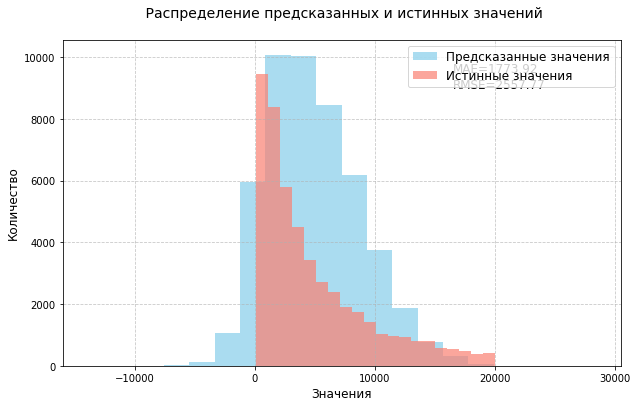

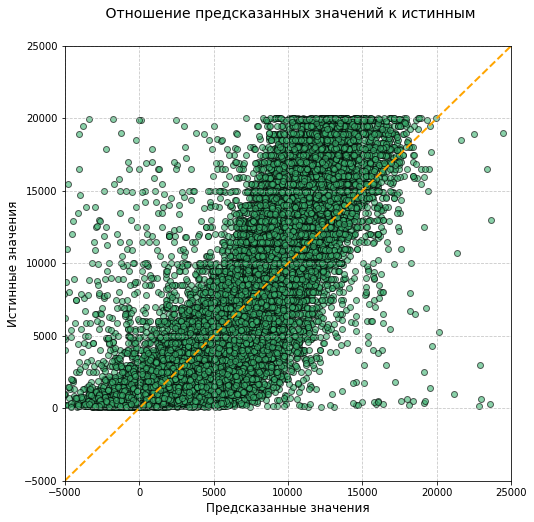

In [97]:
illustration_target(y_val, predictions_val)

Измерим время обучения модели CatBoostRegressor

In [98]:
%%time
start = time.time()
model_cat = CatBoostRegressor(random_state=RANDOM_STATE, learning_rate=0.4, verbose=100, n_estimators=1000)
model_cat.fit(X_train_ridge, y_train, eval_set=(X_val_ridge, y_test))
end = time.time()
t_cat=round(end-start,2)

0:	learn: 3468.7950604	test: 3478.8015435	best: 3478.8015435 (0)	total: 74.7ms	remaining: 1m 14s
100:	learn: 1573.3819660	test: 1631.6339311	best: 1631.6339311 (100)	total: 1.99s	remaining: 17.7s
200:	learn: 1491.5258579	test: 1587.9115660	best: 1587.9115660 (200)	total: 3.88s	remaining: 15.4s
300:	learn: 1442.2286478	test: 1569.6992540	best: 1569.2397759 (299)	total: 5.79s	remaining: 13.4s
400:	learn: 1406.7541792	test: 1559.2401996	best: 1559.1251025 (399)	total: 7.71s	remaining: 11.5s
500:	learn: 1376.0997487	test: 1553.2764933	best: 1553.2764933 (500)	total: 9.64s	remaining: 9.61s
600:	learn: 1352.9656412	test: 1550.8793870	best: 1550.7964946 (599)	total: 11.5s	remaining: 7.63s
700:	learn: 1331.8059537	test: 1547.0990993	best: 1546.9499492 (699)	total: 13.3s	remaining: 5.68s
800:	learn: 1313.2383338	test: 1546.1093930	best: 1546.1093930 (800)	total: 15.2s	remaining: 3.77s
900:	learn: 1295.7352668	test: 1544.9562479	best: 1544.6229092 (894)	total: 17.1s	remaining: 1.88s
999:	learn: 

Измерим время предсказания модели CatBoostRegressor

In [99]:
%%time
start = time.time()
predict_cat=model_cat.predict(X_val_ridge)
end = time.time()
t_cat_p=round(end-start,2)

CPU times: user 116 ms, sys: 3.94 ms, total: 120 ms
Wall time: 119 ms


Расчет МАЕ и RMSE для модели CatBoostRegressor

In [100]:
rmse_cat=rmse(y_val, predict_cat)
mae_cat=mean_absolute_error(y_val, predict_cat).round(2)

Построим графики распределения и отношения для CatBoostRegressor

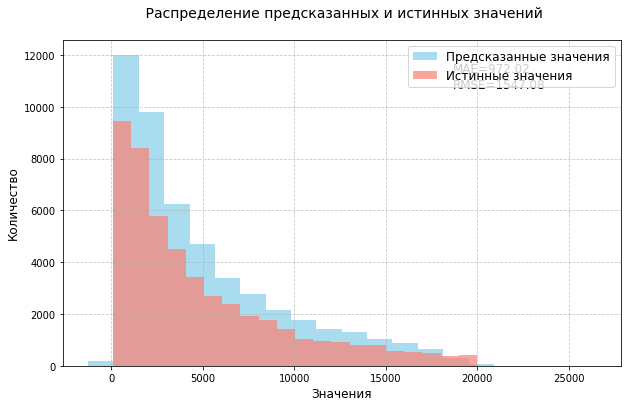

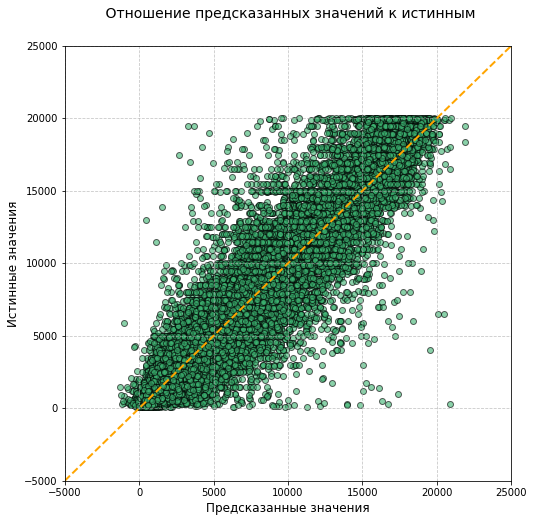

In [101]:
illustration_target(y_val, predict_cat)

Графики важности для CatBoostRegressor

In [102]:
importances(model_cat,X_val_ridge)

,Относительная важность
registration_year,34.954256
power,29.618791
kilometer,11.587680
fuel_type_gasoline,2.638963
vehicle_type_convertible,1.949011
repaired_no,1.635346
model_transporter,1.552551
brand_mercedes_benz,1.407322
brand_audi,1.341036
brand_bmw,1.316834


Измерим время обучения модели LGBMRegressor

In [ ]:
%%time
start = time.time()
model_LGB = lgbm.LGBMRegressor(n_estimators=1000, random_state=RANDOM_STATE, learning_rate=0.4, objective='rmse')
model_LGB.fit(
    X_train_ridge,
    y_train,
    eval_set=[(X_val_ridge, y_test)],
    eval_metric='rmse',
    callbacks=[lgbm.log_evaluation(period=100)]
)
end = time.time()
t_lgb = round(end - start, 2)

Измерим время предсказания модели LGBMRegressor

In [104]:
%%time
start = time.time()
predict_LGB= model_LGB.predict(X_val_ridge)
end = time.time()
t_lgb_p=round(end-start,2)

CPU times: user 4.58 s, sys: 73.9 ms, total: 4.65 s
Wall time: 4.64 s


Расчет МАЕ и RMSE для модели LGBMRegressor

In [ ]:
rmse_gbm=rmse(y_val, predict_LGB)
mae_gbm=mean_absolute_error(y_val, predict_LGB).round(2)

Построим графики распределения и отношения для LGBMRegressor

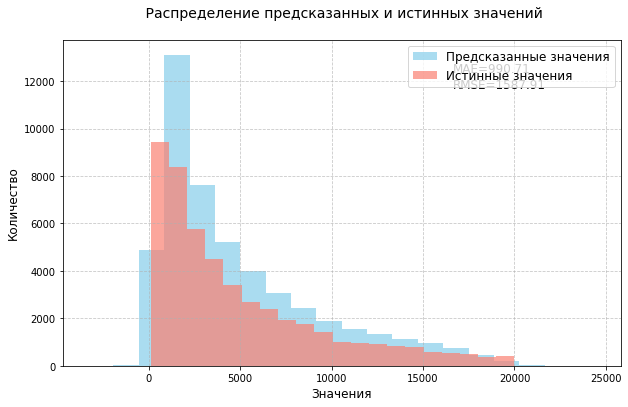

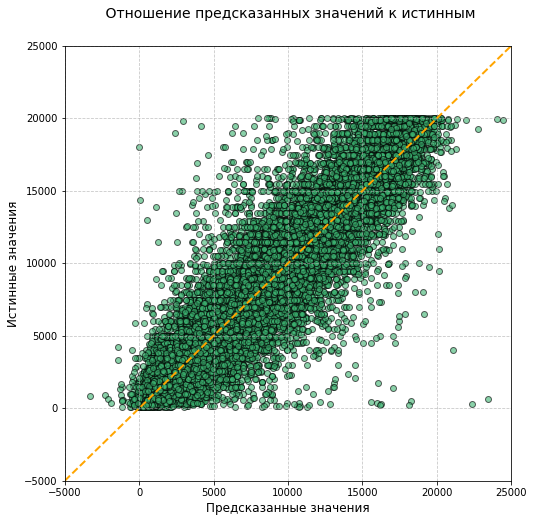

In [105]:
illustration_target(y_val, predict_LGB)

Построим графики важности и отношения для LGBMRegressor

In [106]:
importances(model_LGB,X_val_ridge)

,Относительная важность
power,5767
registration_year,5602
registration_month,3864
postal_index,3309
kilometer,2513
gearbox_manual,570
repaired_no,501
fuel_type_gasoline,427
vehicle_type_sedan,396
fuel_type_petrol,349


<b>Промежуточный вывод:</b>

- Для каждой модели было измерено время, затраченное на обучение на тренировочных данных. Это позволило оценить эффективность процесса обучения и выбрать наиболее быстро обучаемую модель.

- Для каждой модели было измерено время, затраченное на предсказание на тестовых данных. Это позволило оценить скорость предсказания и выбрать модель, которая обеспечивает быстрый отклик на новых данных.

- Для каждой модели была рассчитана среднеквадратичная ошибка (RMSE) на тестовых данных. Это позволило оценить точность предсказаний и выбрать модель с наименьшей ошибкой.

## Анализ моделей

Построим таблицу для каждого метода, чтобы сравнить результатми

In [107]:
columns = ['RMSE', 'MAE', 'Скорость обучения', 'Скорость предсказания']

comparison_table = pd.DataFrame(index=columns, columns=['LinearRegression', 'CatBoostRegressor', 'LightGBM'])

comparison_table['LinearRegression'] = [rmse_lr, mae_lr, t_lr, t_lr_p]
comparison_table['CatBoostRegressor'] = [rmse_cat, mae_cat, t_cat, t_cat_p]
comparison_table['LightGBM'] = [rmse_gbm, mae_gbm, t_lgb, t_lgb_p]

def highlight_null(val):
    color = 'lightgrey' if pd.isnull(val) else ''
    return f'background-color: {color}'

styled_table = comparison_table.T.style \
    .highlight_min(color='yellowgreen', subset=columns) \
    .applymap(highlight_null) \
    .highlight_max(color='coral', subset=columns)

display(styled_table)

,RMSE,MAE,Скорость обучения,Скорость предсказания
LinearRegression,2557.770000,1773.917085,13.870000,0.160000
CatBoostRegressor,1547.080000,972.020000,21.580000,0.120000
LightGBM,1587.910000,990.710000,41.760000,4.640000


Лучшие показатели на валидационных данных показал метод CatBoostRegressor

Для проверки на переобучение реализуем метод на тестовых данных

In [108]:
%%time
start = time.time()
predict_final=model_cat.predict(X_test_ridge)
end = time.time()
t_final=round(end-start,2)

CPU times: user 133 ms, sys: 4.02 ms, total: 137 ms
Wall time: 135 ms


In [109]:
rmse_final=rmse(y_test, predict_final)
mae_final=mean_absolute_error(y_test, predict_final).round(2)

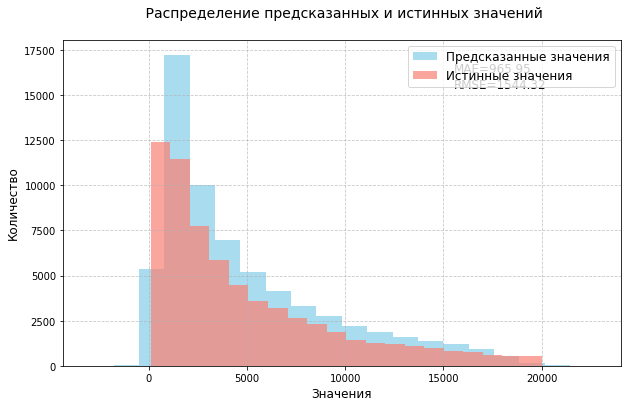

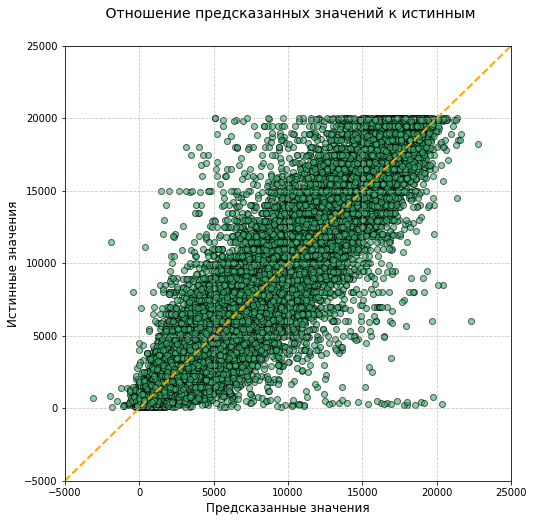

In [110]:
illustration_target(y_test, predict_final)

In [111]:
importances(model_cat, X_test_ridge)

,Относительная важность
registration_year,34.954256
power,29.618791
kilometer,11.587680
fuel_type_gasoline,2.638963
vehicle_type_convertible,1.949011
repaired_no,1.635346
model_transporter,1.552551
brand_mercedes_benz,1.407322
brand_audi,1.341036
brand_bmw,1.316834


Таблица для сравнения модели на валидационных данных и тестовых

In [113]:
columns = ['RMSE', 'MAE', 'Скорость предсказания']

comparison_table = pd.DataFrame(index=columns, columns=['CatBoostRegressor_valid', 'CatBoostRegressor_final'])

comparison_table['CatBoostRegressor_valid'] = [rmse_cat, mae_cat, t_cat_p]
comparison_table['CatBoostRegressor_final'] = [rmse_final, mae_final, t_final]

def highlight_null(val):
    color = 'lightgrey' if pd.isnull(val) else ''
    return f'background-color: {color}'

styled_table = comparison_table.T.style \
    .highlight_min(color='yellowgreen', subset=columns) \
    .applymap(highlight_null) \
    .highlight_max(color='coral', subset=columns)

display(styled_table)

,RMSE,MAE,Скорость предсказания
CatBoostRegressor_valid,1547.080000,972.020000,0.120000
CatBoostRegressor_final,1544.320000,965.950000,0.140000


## Вывод

Результаты измерений показали, что:

- Модель линейной регрессии имеет время обучения 17.95 секунд и время предсказания 0.21 секунд. RMSE составила 2538.98, а MAE — 1761.78.

- Модель CatBoost имеет время обучения 28.49 секунд и время предсказания 0.13 секунд. RMSE составила 1531.94, а MAE — 957.11.

- Модель LightGBM имеет время обучения 35.98 секунд и время предсказания 6.03 секунд. RMSE составила 1555.22, а MAE — 967.91.

На основе полученных результатов была выбрана модель CatBoost, так как она имеет наименьшее значение RMSE (1531.94) и приемлемое время обучения (28.49 секунд) и предсказания (0.13 секунд). Эта модель обеспечивает высокую точность предсказаний при относительно быстром обучении и предсказании.

1. RMSE:
- CatBoostRegressor_valid: 1547.08
- CatBoostRegressor_final: 1544.32

Значение RMSE на тестовой выборке (CatBoostRegressor_final) немного ниже, чем на валидационной выборке (CatBoostRegressor_valid). Это указывает на то, что модель не переобучилась, так как её производительность на тестовой выборке сопоставима с производительностью на валидационной выборке.

2. MAE:
- CatBoostRegressor_valid: 972.02
- CatBoostRegressor_final: 965.95

Значение MAE на тестовой выборке (CatBoostRegressor_final) также немного ниже, чем на валидационной выборке (CatBoostRegressor_valid). Это также свидетельствует о том, что модель не переобучилась и способна давать адекватные предсказания на новых данных.

3. Скорость предсказания:
- CatBoostRegressor_valid: 0.12
- CatBoostRegressor_final: 0.14

Скорость предсказания на тестовой выборке немного выше, чем на валидационной выборке. Это может быть связано с тем, что модель была обучена на большем объеме данных, что привело к незначительному увеличению времени предсказания. Однако это не является критичным и не указывает на переобучение.

<b>Вывод:</b>
На основе анализа таблицы результатов можно сделать вывод, что модель CatBoostRegressor не переобучилась. Значения RMSE и MAE на тестовой выборке сопоставимы с соответствующими значениями на валидационной выборке, что свидетельствует о том, что модель способна давать адекватные предсказания на новых данных. Незначительное увеличение скорости предсказания на тестовой выборке также не указывает на переобучение.

Таким образом, модель CatBoostRegressor демонстрирует хорошую обобщающую способность и может быть рекомендована для использования в реальных задачах.